In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sys
sys.path.append('..')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model

from matplotlib import pyplot as plt

from src.data_loader import data_loader, preprocess_test_image
# from src.networks import pix2pix_generator

In [3]:
# generator = pix2pix_generator()
# generator.load_weights("../saved_models/pix2pix/pix2pix.keras")
generator = load_model('../saved_models/pix2pix/pix2pix.keras')

In [4]:
_, test_ds = data_loader()

In [5]:
def show_images(model, inp, tar=None):
    
    p = model.predict(inp)

    plt.figure(figsize=(6, 3))

    if tar is None:
        display_list = [inp[0], p[0]]
        title = ['Real Face', 'Predicted Face']
    else:
        display_list = [inp[0], tar[0], p[0]]
        title = ['Real Face', 'Comic Face', 'Predicted Face']

    for i in range(len(title)):
        plt.subplot(1, len(title), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 6s 6s/step


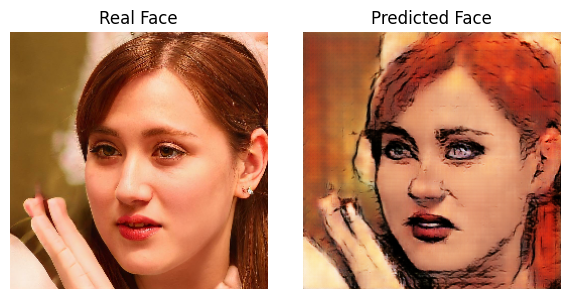

In [6]:
inp = preprocess_test_image("../data/face/5.jpg")
inp = tf.expand_dims(inp, axis=0)

show_images(generator, inp)

1/1 [==============================] - 2s 2s/step


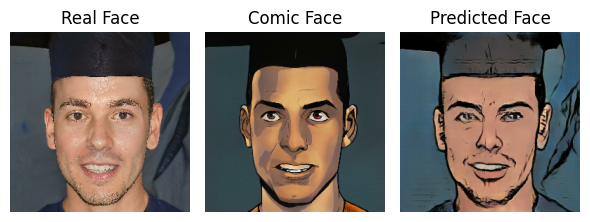

1/1 [==============================] - 0s 40ms/step


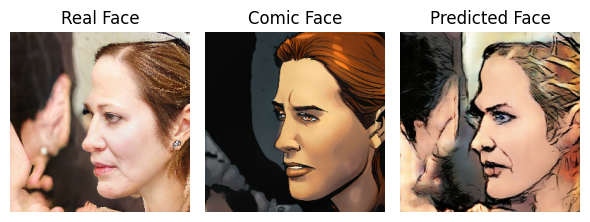

1/1 [==============================] - 0s 49ms/step


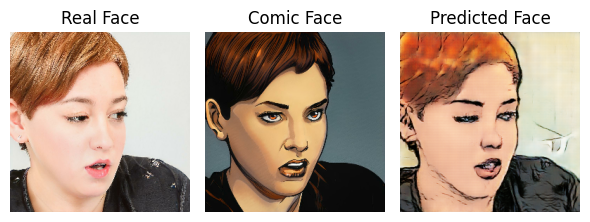

1/1 [==============================] - 0s 52ms/step


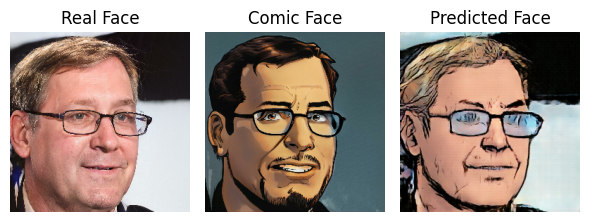

1/1 [==============================] - 0s 23ms/step


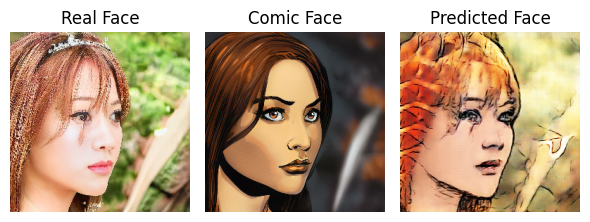

In [7]:
for inp, tar in test_ds.take(5):
    show_images(generator, inp, tar)